In [1]:
import pandas as pd
import numpy as np
import qiime2 as q2
from qiime2.plugins import sample_classifier, greengenes2
import biom

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data_dict_16s = { 
    'ANX_All': biom.load_table('../Updated_Data/RF_Data/LIBR_Data/Amp_ANX_uncollapsed.biom'),
    'MDD_All': biom.load_table('../Updated_Data/RF_Data/LIBR_Data/Amp_MDD_uncollapsed.biom')
}

'''
data_dict_16s = {
    'ANX_ONLY': biom.load_table(data_dir + 'Amp_ANX_ONLY_uncollapsed.biom'),
    'ANX': biom.load_table(data_dir + 'Amp_ANX_ONLY_uncollapsed.biom'), 
    'MDD_ONLY': biom.load_table(data_dir + 'Amp_MDD_ONLY_uncollapsed.biom'),
    'MDD': biom.load_table(data_dir + 'Amp_MDD_uncollapsed.biom'),
    'ANX_OR_MDD': biom.load_table(data_dir + 'Amp_MDD_OR_ANX_uncollapsed.biom'),
    'ANX_AND_MDD': biom.load_table(data_dir + 'Amp_MDD_AND_ANX_uncollapsed.biom'), 
}
'''

metadata = pd.read_csv('../Updated_Data/RF_Data/LIBR_Data/metadata.tsv', sep='\t', index_col=0)
#metadata = metadata.loc[metadata.index.intersection(data_dict_16s['ANX_All'].ids())]
#metadata['anxiety_cat'] = np.where((metadata['DX_ANX'] == True) & ((metadata['N05B_Anxiolytics'] == True) | (metadata['N06A_Antidepressants'] == True)) , 'Medicated Anxiety', 
#                                   np.where((metadata['DX_ANX'] == True) & (metadata['N05B_Anxiolytics'] == False) & (metadata['N06A_Antidepressants'] == False), 'Unmedicated Anxiety', 
#                                            'Healthy Control'))

unmed_table = biom.load_table('../Updated_Data/Medications_Data/unmedicated_table.biom')
unmedicated_anx = unmed_table.to_dataframe().columns.intersection(data_dict_16s['ANX_All'].ids())
unmedicated_mdd = unmed_table.to_dataframe().columns.intersection(data_dict_16s['MDD_All'].ids())
data_dict_16s['ANX_Unmedicated'] = data_dict_16s['ANX_All'].filter(unmedicated_anx, inplace=False)
data_dict_16s['MDD_Unmedicated'] = data_dict_16s['MDD_All'].filter(unmedicated_mdd, inplace=False)

sig_asvs_anx = pd.read_csv('../Updated_Data/sig_asvs_birdman.csv')['asv'].values
sig_asvs_mdd = pd.read_csv('../Updated_Data/sig_asvs_mdd_birdman.csv')['asv'].values
for k in ['ANX_All', 'ANX_Unmedicated']: 
    data_dict_16s[k + '_Birdman_Sig'] = data_dict_16s[k].filter(sig_asvs_anx, axis='observation', inplace=False)
for k in ['MDD_All', 'MDD_Unmedicated']: 
    data_dict_16s[k + '_Birdman_Sig'] = data_dict_16s[k].filter(sig_asvs_mdd, axis='observation', inplace=False)

In [3]:
data_dict_16s

{'ANX_All': 10753 x 496 <class 'biom.table.Table'> with 81135 nonzero entries (1% dense),
 'MDD_All': 13654 x 635 <class 'biom.table.Table'> with 105541 nonzero entries (1% dense),
 'ANX_Unmedicated': 10753 x 322 <class 'biom.table.Table'> with 54404 nonzero entries (1% dense),
 'MDD_Unmedicated': 13654 x 396 <class 'biom.table.Table'> with 66539 nonzero entries (1% dense),
 'ANX_All_Birdman_Sig': 89 x 496 <class 'biom.table.Table'> with 9170 nonzero entries (20% dense),
 'ANX_Unmedicated_Birdman_Sig': 89 x 322 <class 'biom.table.Table'> with 6046 nonzero entries (21% dense),
 'MDD_All_Birdman_Sig': 87 x 635 <class 'biom.table.Table'> with 11716 nonzero entries (21% dense),
 'MDD_Unmedicated_Birdman_Sig': 87 x 396 <class 'biom.table.Table'> with 7546 nonzero entries (21% dense)}

In [4]:
gg2_tax = q2.Artifact.load('../Updated_Data/2022.10.taxonomy.asv.nwk.qza')
gg2_tree = q2.Artifact.load('../Updated_Data/2022.10.phylogeny.asv.nwk.qza')

In [6]:
gg2_class_16s = greengenes2.methods.taxonomy_from_table(reference_taxonomy=gg2_tax, 
                                                        table=q2.Artifact.import_data('FeatureTable[Frequency]', 
                                                                                      data_dict_16s['ANX_All']))
gg2_taxonomy_16s = gg2_class_16s.classification

'''
gg2_class_metag = greengenes2.methods.taxonomy_from_table(reference_taxonomy=gg2_tax, 
                                                          table=tables_for_analysis['MetaG_NG_MDD_OR_ANX'])
gg2_taxonomy_metag = gg2_class_metag.classification
'''

"\ngg2_class_metag = greengenes2.methods.taxonomy_from_table(reference_taxonomy=gg2_tax, \n                                                          table=tables_for_analysis['MetaG_NG_MDD_OR_ANX'])\ngg2_taxonomy_metag = gg2_class_metag.classification\n"

In [4]:
def rf_classifier(ft, md, col, n_folds, stratified=False): 
    X = ft.to_dataframe().T.copy()
    md_sub = md.loc[md.index.intersection(X.index)]
    if col == 'Medicated':
        md_sub[col].replace({'Un-medicated': 0, 'Medicated': 1}, inplace=True)
    elif col == 'DX_ANX': 
        md_sub[col].replace({True: 1, False: 0}, inplace=True)
    elif col == 'anxiety_cat': 
        md_sub[col].replace({'Healthy Control': 0, 'Medicated Anxiety': 1,  'Unmedicated Anxiety': 2}, inplace=True)
    else:    
        md_sub[col].replace({'Healthy Control': 0, 'Mood/Anxiety': 1}, inplace=True)
    y = md_sub[col]
    
    if stratified: 
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=6) 
        kf_split = skf.split(X, y)
    else: 
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=6)
        kf_split = kf.split(X)
    
    # conversion between index and SampleID
    i_to_id = {i:X.index[i] for i in range(len(X.index))}
    
    list_of_aucs = []
    list_of_importances = []
    # iterate through each of the splits 
    for i, (train_index, test_index) in enumerate(kf_split):
        train_ids = [i_to_id[j] for j in train_index]
        test_ids = [i_to_id[k] for k in test_index]
        
        train_X = X.loc[train_ids]
        train_y = y.loc[train_ids]
        test_X = X.loc[test_ids]
        test_y = y.loc[test_ids] 

        regr = RandomForestClassifier()
        regr.fit(train_X, train_y)
        y_pred = regr.predict_proba(test_X)
        
        # get feature importances using feature permutation
        result = permutation_importance(regr, test_X, test_y, n_repeats=10, random_state=28, n_jobs=5)
        forest_importances = pd.DataFrame(data={'importances': result.importances_mean}, index=X.columns)
        forest_importances['fold'] = i
        
        
        fpr, tpr, _ = roc_curve(test_y.values, y_pred[:, 1])
        auc = roc_auc_score(test_y.values, y_pred[:, 1])
        list_of_aucs.append(auc)
        list_of_importances.append(forest_importances)
        sns.lineplot(x=fpr, y=tpr, errorbar=None, label='fold ' + str(i) + '; AUC = ' + str(np.round(auc, 3)))
        
    return pd.DataFrame(data={'auc': list_of_aucs, 'fold': range(n_folds)}), pd.concat(list_of_importances)

KeyboardInterrupt: 

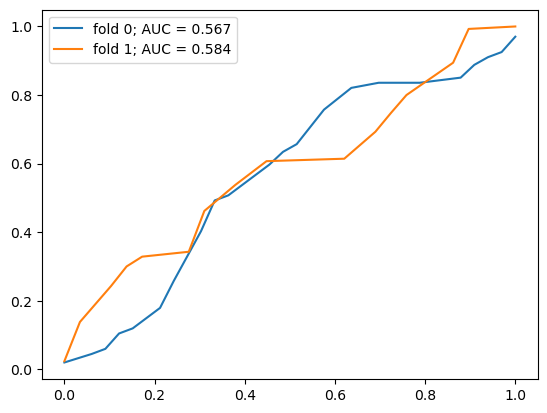

In [5]:
anx_all, anx_all_fi = rf_classifier(data_dict_16s['ANX_All'], metadata, 'DX_ANX', 5, True)
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='--', color='gray')
print(anx_unmed['auc'].mean())
plt.title('Anxiety RF Classifier: All Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

0.6449200567908976


Text(0, 0.5, 'True Positive Rate')

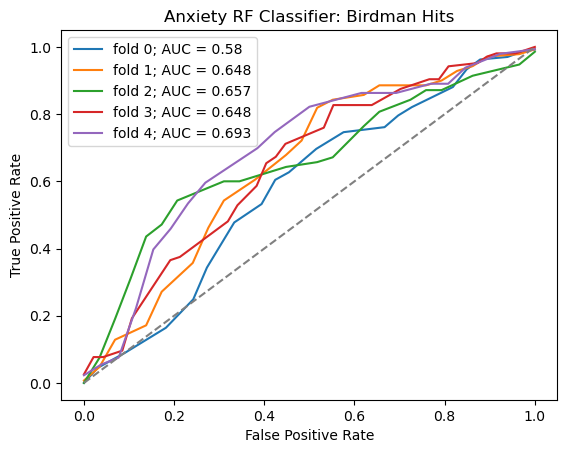

In [15]:
anx_unmed_bd = rf_classifier(data_dict_16s['ANX_All_Birdman_Sig'], metadata, 'DX_ANX', 5, True)
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='--', color='gray')
print(anx_unmed_bd['auc'].mean())
plt.title('Anxiety RF Classifier: Birdman Hits')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

0.7174671352612081


Text(0, 0.5, 'True Positive Rate')

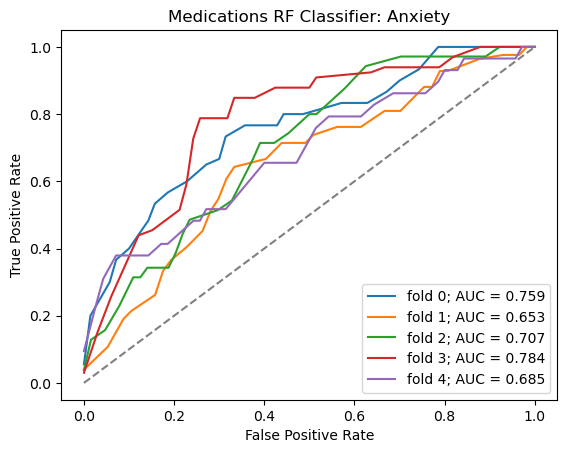

In [22]:
anx_unmed_med = rf_classifier(data_dict_16s['ANX_All'], metadata, 'Medicated', 5, True)
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='--', color='gray')
print(anx_unmed_med['auc'].mean())
plt.title('Medications RF Classifier: Anxiety')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
mdd_all, mdd_all_fi = rf_classifier(data_dict_16s['MDD_All'], metadata, 'DX_MDD', 5, True)
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='--', color='gray')
print(mdd_all['auc'].mean())
plt.title('Depression RF Classifier: All Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

0.6706866057442573


Text(0, 0.5, 'True Positive Rate')

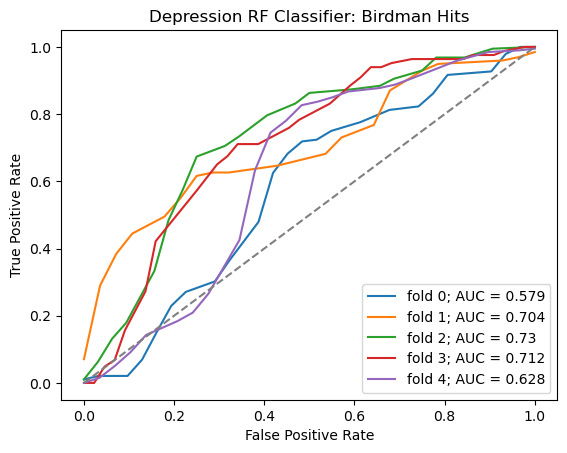

In [24]:
mdd_all_bd = rf_classifier(data_dict_16s['MDD_All_Birdman_Sig'], metadata, 'DX_MDD', 5, True)
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='--', color='gray')
print(mdd_all_bd['auc'].mean())
plt.title('Depression RF Classifier: Birdman Hits')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

0.686320371015242


Text(0, 0.5, 'True Positive Rate')

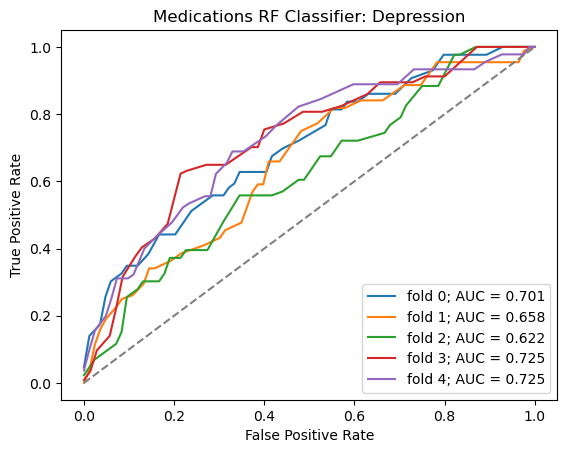

In [27]:
med_all_mdd = rf_classifier(data_dict_16s['MDD_All'], metadata, 'Medicated', 5, True)
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='--', color='gray')
print(med_all_mdd['auc'].mean())
plt.title('Medications RF Classifier: Depression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [96]:
def rf_classifier_multi(ft, md, col, n_folds, stratified=False): 
    X = ft.copy()
    md_sub = md.loc[md.index.intersection(X.index)]
    y = md_sub[col]
    
    if stratified: 
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=6) 
        kf_split = skf.split(X, y)
    else: 
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=6)
        kf_split = kf.split(X)
    
    # conversion between index and SampleID
    i_to_id = {i:X.index[i] for i in range(len(X.index))}
    
    full_test = []
    full_preds = []
    # iterate through each of the splits 
    for i, (train_index, test_index) in enumerate(kf_split):
        train_ids = [i_to_id[j] for j in train_index]
        test_ids = [i_to_id[k] for k in test_index]
        
        train_X = X.loc[train_ids]
        train_y = y.loc[train_ids]
        test_X = X.loc[test_ids]
        test_y = y.loc[test_ids] 
        
       
        label_binarizer = LabelBinarizer().fit(train_y)
        y_onehot_test = label_binarizer.transform(test_y)

        regr = RandomForestClassifier()
        regr.fit(train_X, train_y)
        y_pred = regr.predict_proba(test_X)
        
        #fig, ax = plt.subplots(figsize=(6, 6))
        
        full_test.append(y_onehot_test)
        full_preds.append(y_pred) 
        
        '''
        for c in y.unique():
            class_of_interest = c
            class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
            RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_pred[:, class_id],
                name=f"ROC curve for {c}", 
                ax=ax
            )
        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate') 
        plt.xlabel('False Postive Rate')
        plt.title(f'ROC Curve: One to Rest THDMI Cohort - Fold = {i}') 
        plt.legend()
        '''
        #save_name = 'results/roc_curve_fold_' + str(i) + '.pdf'
        #plt.savefig(save_name)
    return np.concatenate(full_test), np.concatenate(full_preds)

<AxesSubplot:>

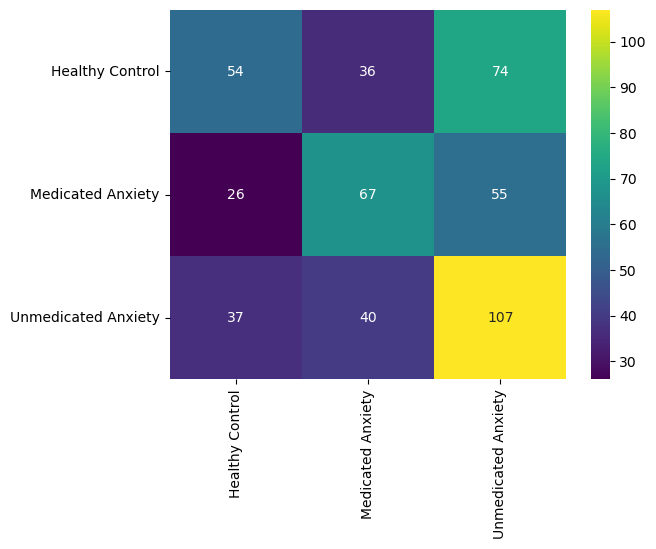

In [111]:
accurate, preds = rf_classifier_multi(data_dict_16s['ANX_All'].to_dataframe().T, metadata, 'anxiety_cat', 5)
results = pd.DataFrame(accurate, 
                       columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety']).idxmax(axis=1).values
preds = pd.DataFrame(preds, 
                     columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety']).idxmax(axis=1).values
confusion = pd.DataFrame(confusion_matrix(results, preds),
                         columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety'], 
                         index=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety'])
sns.heatmap(confusion, cmap='viridis', annot=True, fmt=".0f")

<AxesSubplot:>

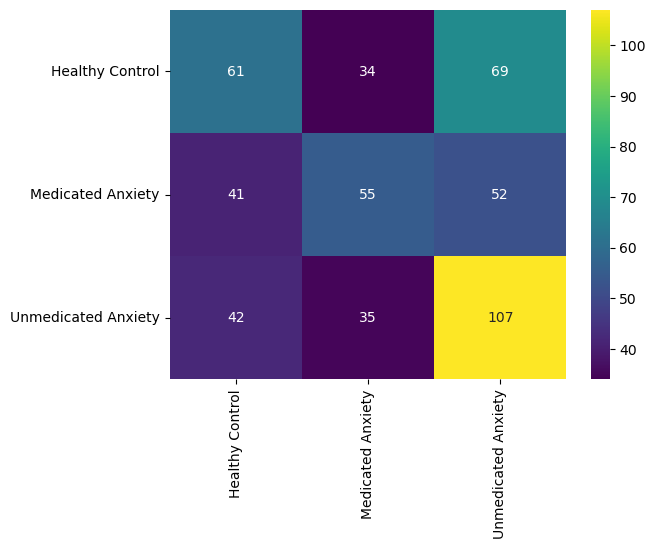

In [112]:
accurate, preds = rf_classifier_multi(data_dict_16s['ANX_All_Birdman_Sig'].to_dataframe().T, metadata, 'anxiety_cat', 5)
results = pd.DataFrame(accurate, 
                       columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety']).idxmax(axis=1).values
preds = pd.DataFrame(preds, 
                     columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety']).idxmax(axis=1).values
confusion = pd.DataFrame(confusion_matrix(results, preds),
                         columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety'], 
                         index=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety'])
sns.heatmap(confusion, cmap='viridis', annot=True, fmt=".0f")

In [99]:
results = pd.DataFrame(accurate, columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety']).idxmax(axis=1).values
preds = pd.DataFrame(preds, columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety']).idxmax(axis=1).values

In [108]:
pd.DataFrame(confusion_matrix(results, preds),
             columns=['Healthy Control', 'Medicated Anxiety', 'Unmedicated Anxiety'])

,Healthy Control,Medicated Anxiety,Unmedicated Anxiety
0,52,34,78
1,24,64,60
2,44,33,107


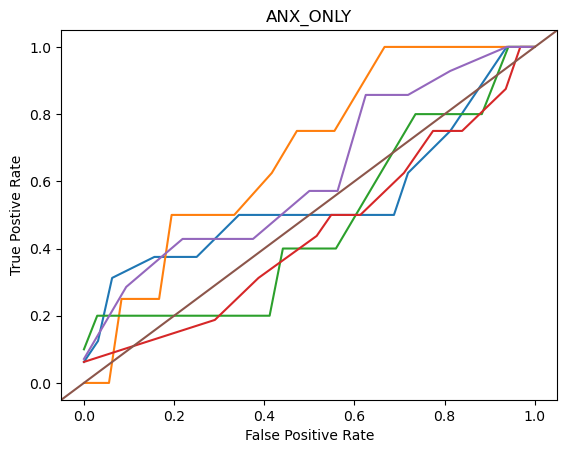

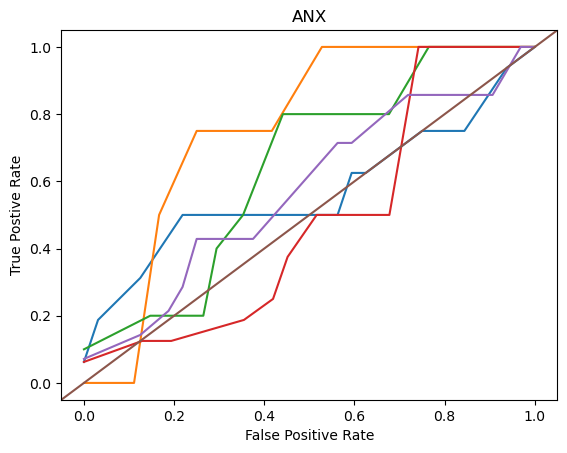

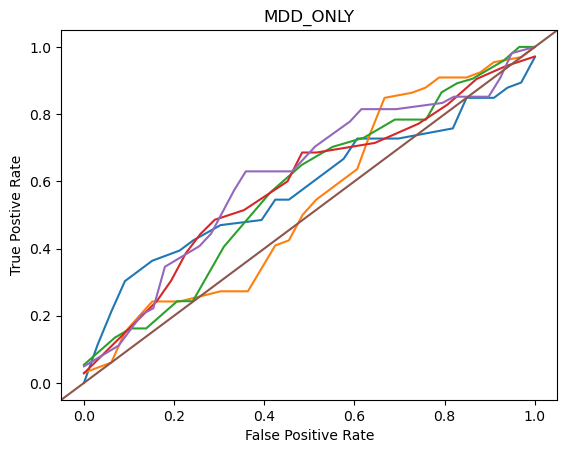

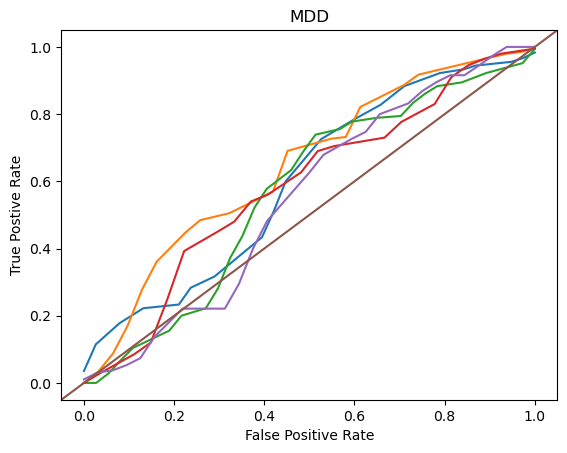

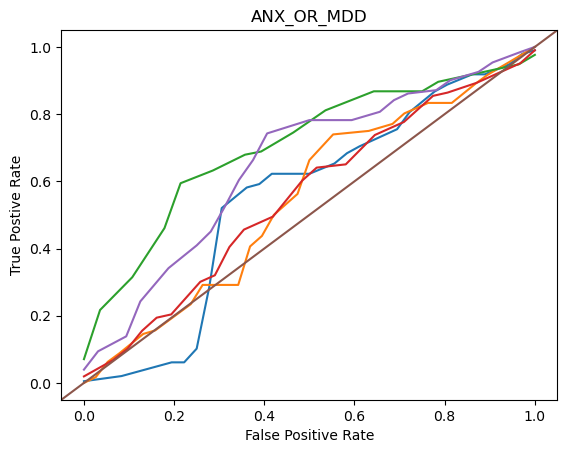

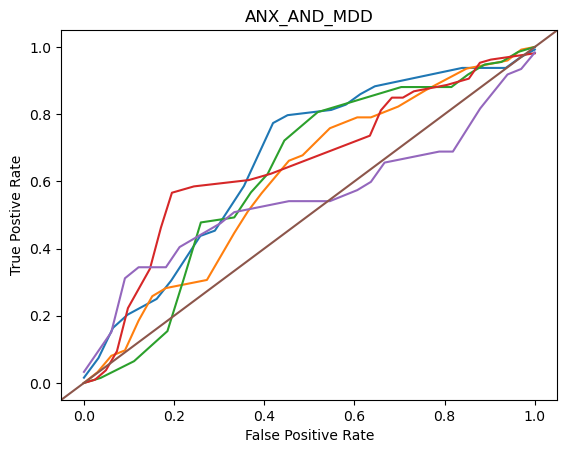

In [5]:
list_of_aucs = []
list_of_importances =[]
for k in data_dict_16s: 
    if 'COMP' in k: 
        col = 'DX_MDD'
    else: 
        col = 'GroupAssignment'
    df, imp = rf_classifier(data_dict_16s[k], metadata, col, 5)
    df['Group'] = k
    df['Stratified'] = 'No'
    imp['Group'] = k
    imp['Stratified'] = 'No'
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(k)
    ax = plt.gca()
    ax.plot([0,1],[0,1], transform=ax.transAxes)
    plt.show()
    list_of_aucs.append(df)
    list_of_importances.append(imp)
    
    '''
    df, imp = rf_classifier(data_dict_16s[k], metadata, col, 5, True)
    df['Group'] = k
    df['Stratified'] = 'Yes'
    imp['Group'] = k
    imp['Stratified'] = 'Yes'
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(k + '_STRATIFIED')
    ax = plt.gca()
    ax.plot([0,1],[0,1], transform=ax.transAxes)
    plt.show()
    list_of_aucs.append(df)
    list_of_importances.append(imp)
    '''

In [7]:
full_results = pd.concat(list_of_aucs)
full_results

,auc,fold,Group,Stratified
0,0.548828,0,ANX_ONLY,No
1,0.680556,1,ANX_ONLY,No
2,0.473529,2,ANX_ONLY,No
3,0.445565,3,ANX_ONLY,No
4,0.625000,4,ANX_ONLY,No
0,0.570312,0,ANX,No
1,0.760417,1,ANX,No
2,0.650000,2,ANX,No
3,0.485887,3,ANX,No
4,0.578125,4,ANX,No


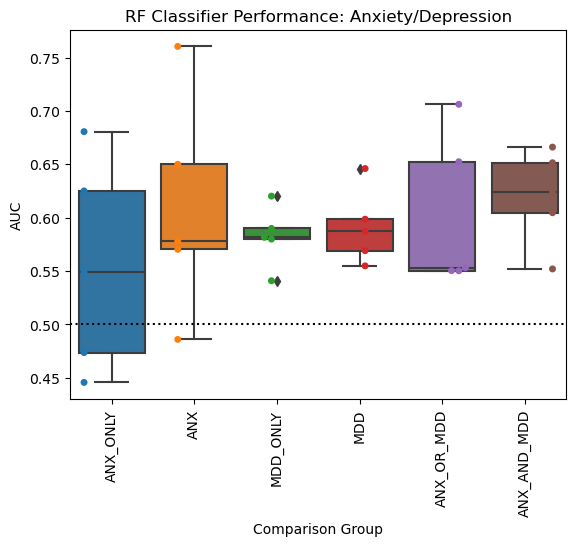

In [23]:
sns.swarmplot(data=full_results, x='Group', y='auc', hue='Group', dodge=True)
sns.boxplot(data=full_results, x='Group', y='auc')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.xticks(rotation=90)
plt.xlabel('Comparison Group')
plt.ylabel('AUC')
plt.hlines(0.5, -0.5, 5.5, linestyles="dotted", colors=['k'])
plt.xlim(-0.5, 5.5)
plt.title('RF Classifier Performance: Anxiety/Depression')
plt.legend([],[], frameon=False)

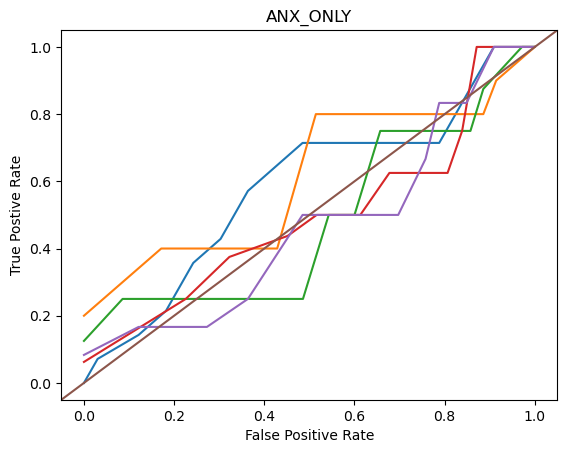

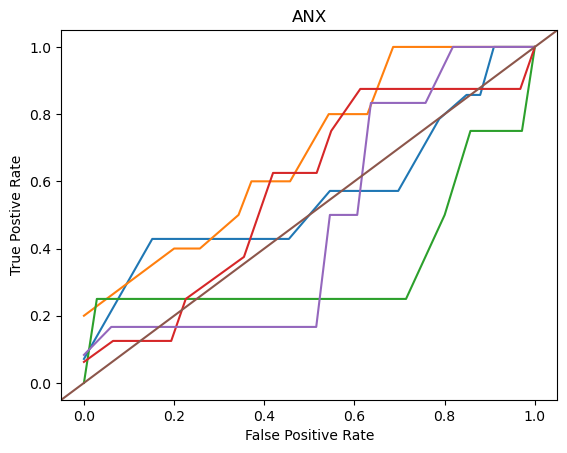

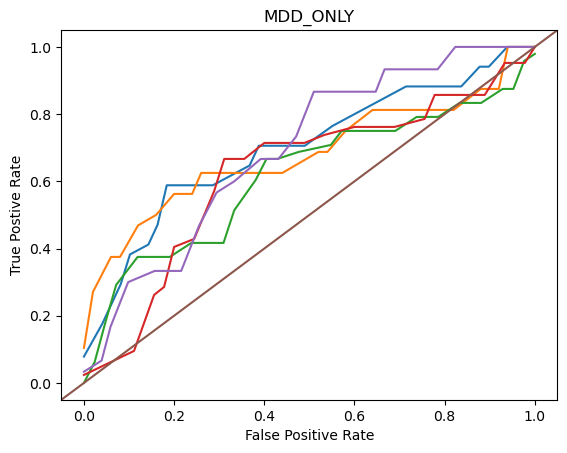

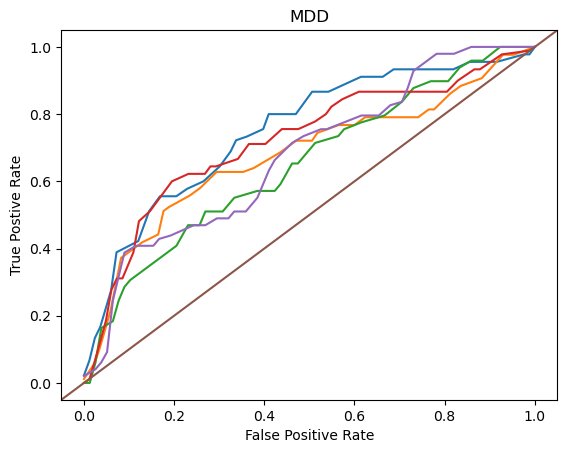

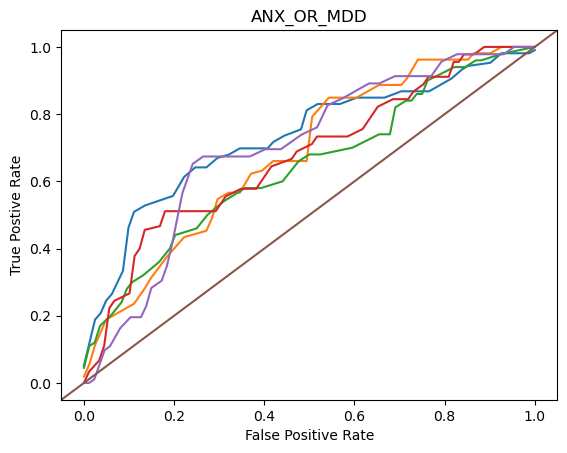

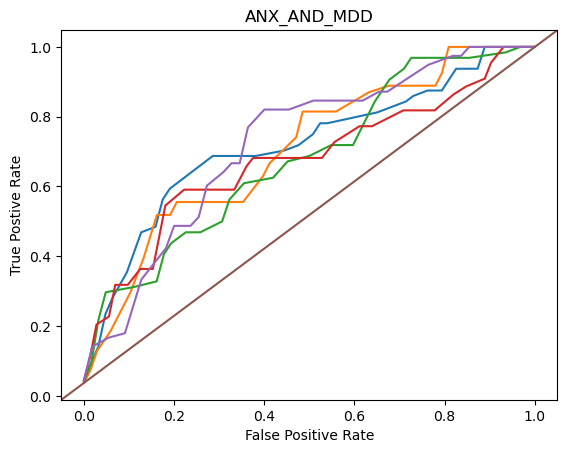

In [19]:
list_of_aucs = []
list_of_importances =[]
for k in data_dict_16s: 
    df, imp = rf_classifier(data_dict_16s[k], metadata, 'Medicated', 5)
    df['Group'] = k
    df['Stratified'] = 'No'
    imp['Group'] = k
    imp['Stratified'] = 'No'
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(k)
    ax = plt.gca()
    ax.plot([0,1],[0,1], transform=ax.transAxes)
    plt.show()
    list_of_aucs.append(df)
    list_of_importances.append(imp)

In [20]:
med_results = pd.concat(list_of_aucs)

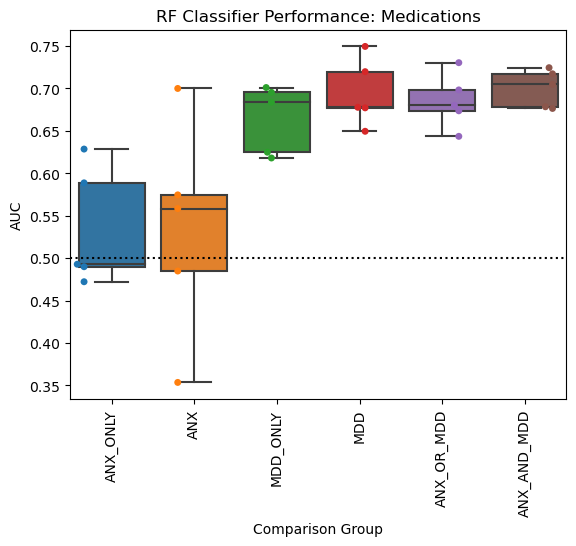

In [22]:
sns.swarmplot(data=med_results, x='Group', y='auc', hue='Group', dodge=True)
sns.boxplot(data=med_results, x='Group', y='auc')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.xticks(rotation=90)
plt.xlabel('Comparison Group')
plt.ylabel('AUC')
plt.hlines(0.5, -0.5, 5.5, linestyles="dotted", colors=['k'])
plt.xlim(-0.5, 5.5)
plt.title('RF Classifier Performance: Medications')
plt.legend([],[], frameon=False)

In [8]:
#all_importances = pd.concat(list_of_importances)
#all_importances.to_csv('../Updated_Results/feature_importances_rf.csv')


'''
all_importances = pd.read_csv('../Updated_Results/feature_importances_rf.csv', index_col=0)
gg2_taxonomy = gg2_taxonomy_16s.view(pd.DataFrame)
importances_taxa = all_importances.merge(gg2_taxonomy, right_index=True, left_index=True, how='left')

importances_taxa[['domain', 'phylum', 'class', 'order', 
                  'family', 'genus', 'species']] = importances_taxa['Taxon'].str.split(';', expand=True)
'''

imp_collapsed = pd.concat(list_of_importances)
imp_collapsed.to_csv('../Updated_Results/feature_importances_collapsed.csv')

In [33]:
imp_collapsed_mdd_anx = imp_collapsed.loc[(imp_collapsed.Group == 'ANX_AND_MDD') & 
                                          (imp_collapsed.Stratified == 'Yes')]
imp_collapsed_mdd_anx

,importances,fold,Group,Stratified
g__Peptococcus,-0.001111,0,ANX_AND_MDD,Yes
g__Gemmiger_A_73129,-0.004444,0,ANX_AND_MDD,Yes
g__Ruthenibacterium,-0.006667,0,ANX_AND_MDD,Yes
g__Faecalibacterium,0.004444,0,ANX_AND_MDD,Yes
g__Anaerofilum_74150,0.000000,0,ANX_AND_MDD,Yes
...,...,...,...,...
g__Coprococcus_A_121497,0.000000,4,ANX_AND_MDD,Yes
g__CAG-127,0.000000,4,ANX_AND_MDD,Yes
g__Lagierella,0.000000,4,ANX_AND_MDD,Yes
g__Fusobacterium_C,-0.002247,4,ANX_AND_MDD,Yes


In [26]:
imp_collapsed_mdd = imp_collapsed.loc[(imp_collapsed.Group == 'MDD_ONLY') & 
                                      (imp_collapsed.Stratified == 'Yes')]['importances'].sort_values(ascending=False)

In [28]:
imp_collapsed_mdd[:25]

g__Bacteroides_H             0.057143
g__Bifidobacterium_388775    0.055556
g__Sutterella                0.046032
g__Escherichia_710834        0.046032
g__Gemmiger_A_73129          0.044444
g__Roseburia                 0.039683
g__Lawsonibacter             0.038095
g__Gemmiger_A_73129          0.036508
g__Faecalibacillus           0.034921
g__Faecalimonas              0.030159
o__Christensenellales        0.030159
g__Merdisoma                 0.030159
g__Coprococcus_A_121497      0.028571
g__Bifidobacterium_388775    0.028571
g__Haemophilus_D_735815      0.026984
g__Ruminococcus_E            0.026984
g__Gemmiger_A_73129          0.026984
g__Muricomes_149725          0.026984
g__Acetatifactor             0.026984
g__Dysosmobacter             0.025397
g__Phocea                    0.025397
g__Sutterella                0.025397
g__Eubacterium_F             0.023810
g__CAG-273                   0.023810
g__Oliverpabstia             0.023810
Name: importances, dtype: float64

In [34]:
top_importances = imp_collapsed_mdd_anx.sort_values(by='importances', ascending=False)[:25].index

In [35]:
top_importances

Index(['g__CAG-273', 'g__Bifidobacterium_388775', 'g__Coprococcus_A_121497',
       'g__Bacteroides_H', 'g__Enterocloster', 'g__Holdemanella',
       'g__Roseburia', 'g__Eubacterium_F', 'g__Streptococcus',
       'g__Clostridium_Q_135822', 'g__Phascolarctobacterium_A',
       'g__Parabacteroides_B_862066', 'g__UBA1417', 'g__Eubacterium_F',
       'g__Ruminiclostridium_E', 'g__Haemophilus_D_735815', 'g__Lachnospira',
       'g__Lactobacillus', 'g__CAG-95', 'g__Parasutterella',
       'g__Neisseria_563205', 'g__Coprococcus_A_187866', 'g__Lawsonibacter',
       'g__Roseburia', 'g__Lachnoclostridium_B'],
      dtype='object')

In [24]:
mdd_importances = importances_taxa.loc[importances_taxa.Group == 'MDD_ONLY'].sort_values(by='importances', 
                                                                                         ascending=False)
mdd_importances.loc[mdd_importances.importances > 0]

,importances,fold,Group,Stratified,Taxon,Confidence,domain,phylum,class,order,family,genus,species
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTTTTGCAAGTCTGAAGTGAAAGCCCGGGGCTTAACCCCGGGACTGCTTTGGAAACTGTAGGACTAGAGTGCAGGAGAGGTAAGTGGAATTCCTAG,5.238095e-02,3,MDD_ONLY,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Acetatifactor,s__Acetatifactor sp900066565
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGATGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTATGGCTAGAGTGCTGGAGAGGTAAGCGGAATTCCTAG,5.079365e-02,2,MDD_ONLY,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Copromonas,s__Copromonas sp900066535
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTGATTTAAGTCAGCGGTGAAAGTTTGTGGCTCAACCATAAAATTGCCGTTGAAACTGGGTTACTTGAGTGTGTTTGAGGTAGGCGGAATGCGTGG,4.603175e-02,3,MDD_ONLY,No,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.0,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Tannerellaceae,g__Parabacteroides_B_862066,s__Parabacteroides_B_862066 merdae
TACGGAGGATTCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATTTCGGGGCTCAACCCTGAACGTGCCTCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGG,4.126984e-02,3,MDD_ONLY,No,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.0,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes_A_871400,s__Alistipes_A_871400 putredinis
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,3.809524e-02,3,MDD_ONLY,Yes,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.0,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Phocaeicola_A_858004,s__Phocaeicola_A_858004 vulgatus
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGTCTCAAGTCGAATGTTAAATCTACCGGCTCAACTGGTAGCTGCGTTCGAAACTGGGGCTCTTGAGTGAAGTAGAGGCAGGCGGAATTCCTAGT,1.110223e-17,2,MDD_ONLY,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Ruminococcaceae,g__Phocea,s__Phocea massiliensis
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCTTAGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGGACTGCTTTGGAAACTGTTAAGCTGGAGTGCTGGAGAGGTAAGCGGAATTCCTAG,1.110223e-17,2,MDD_ONLY,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Clostridium_Q_135853,s__Clostridium_Q_135853 saccharolyticum_A
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGTGCAGGCGGCTCGATAAGTCTGATGTGAAAGCCTTCGGCTCAACCGGAGAATTGCATCAGAAACTGTCGAGCTTGAGTACAGAAGAGGAGAGTGGAACTCCATG,1.110223e-17,4,MDD_ONLY,No,d__Bacteria; p__Firmicutes_D; c__Bacilli; o__L...,1.0,d__Bacteria,p__Firmicutes_D,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus iners
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGACGCAAGTCTGGAGTGAAAGCCCGGGGCCCAACCCCGGGACTGCTTTGGAAACTGTGCTGCTGGAGTGCAGGAGAGGTAAGTGGAATTCCTAG,1.110223e-17,4,MDD_ONLY,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Enterocloster,s__Enterocloster aldenensis


In [19]:
#anx_importances = importances_taxa.loc[importances_taxa.Group == 'ANX_ONLY'].sort_values(by='importances', 
#                                                                                         ascending=False)
#anx_importances

In [25]:
anx_or_mdd = importances_taxa.loc[importances_taxa.Group == 'ANX_OR_MDD']
anx_or_mdd.loc[anx_or_mdd.importances > 0]

,importances,fold,Group,Stratified,Taxon,Confidence,domain,phylum,class,order,family,genus,species
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTCTGTTAAGTCAGATGTGAAAGGTTAGGGCTCAACCCTGAACGTGCATCTGATACTGGCAGACTTGAGTATGGAAGAGGTAAGTGGAATTCCTAG,0.007874,0,ANX_OR_MDD,No,d__Bacteria; p__Firmicutes_B_370539; c__Peptoc...,1.0,d__Bacteria,p__Firmicutes_B_370539,c__Peptococcia,o__Peptococcales,f__Peptococcaceae_369362,g__Peptococcus,s__Peptococcus niger
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGCTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGG,0.004724,1,ANX_OR_MDD,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Ruminococcaceae,g__Gemmiger_A_73129,s__Gemmiger_A_73129 formicilis_72474
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGCTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGG,0.003150,0,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Ruminococcaceae,g__Gemmiger_A_73129,s__Gemmiger_A_73129 formicilis_72474
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGCTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGG,0.003150,1,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Ruminococcaceae,g__Gemmiger_A_73129,s__Gemmiger_A_73129 formicilis_72474
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGCTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGG,0.002362,2,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Ruminococcaceae,g__Gemmiger_A_73129,s__Gemmiger_A_73129 formicilis_72474
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAAGGCAAGTCTGAAGTGAAAATCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTGGAGTACAGGAGAGGTAAGTGGAATTCCTAG,0.001575,0,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Coprococcus_A_121497,s__Coprococcus_A_121497 eutactus
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAAGGCAAGTCTGAAGTGAAAATCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTGGAGTACAGGAGAGGTAAGTGGAATTCCTAG,0.007874,1,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Coprococcus_A_121497,s__Coprococcus_A_121497 eutactus
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAAGGCAAGTCTGAAGTGAAAATCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTGGAGTACAGGAGAGGTAAGTGGAATTCCTAG,0.001575,2,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Coprococcus_A_121497,s__Coprococcus_A_121497 eutactus
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAAGGCAAGTCTGAAGTGAAAATCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTGGAGTACAGGAGAGGTAAGTGGAATTCCTAG,0.002362,4,ANX_OR_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Coprococcus_A_121497,s__Coprococcus_A_121497 eutactus


In [27]:
anx_and_mdd = importances_taxa.loc[importances_taxa.Group == 'ANX_AND_MDD'].sort_values(by='importances', 
                                                                                        ascending=False)
anx_and_mdd.loc[anx_and_mdd.importances > 0]

,importances,fold,Group,Stratified,Taxon,Confidence,domain,phylum,class,order,family,genus,species
TACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACG,3.146067e-02,4,ANX_AND_MDD,Yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A_737866,f__Pasteurellaceae,g__Haemophilus_D_735815,s__Haemophilus_D_735815 parainfluenzae
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATTGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGGATGGAAACTGCCAATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGT,2.921348e-02,4,ANX_AND_MDD,Yes,d__Bacteria; p__Firmicutes_C; c__Negativicutes...,1.0,d__Bacteria,p__Firmicutes_C,c__Negativicutes,o__Veillonellales,f__Veillonellaceae,g__Veillonella_A,s__Veillonella_A dispar
TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCGAGGCAAGTCAGGCGTGAAATCTATGGGCTTAACCCATAAACTGCGCTTGAAACTGTCTTGCTTGAGTGAAGTAGAGGTAGGCGGAATTCCCGG,2.777778e-02,1,ANX_AND_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Acutalibacteraceae,g__Clostridium_A,s__Clostridium_A leptum
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGG,2.666667e-02,1,ANX_AND_MDD,Yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A_737866,f__Enterobacteriaceae_A,g__Escherichia_710834,s__Escherichia fergusonii
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,2.555556e-02,1,ANX_AND_MDD,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,s__Faecalibacterium prausnitzii_C_71351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGGGAGCGTAGGCGGTCTGATAAGTTGGATGTGAAATACCCGGGCTTAACTTGGGGGGTGCATCCAATACTGTTGGACTAGAGTACAGGAGAGGAAAGCGGAATTCCTAG,1.110223e-17,3,ANX_AND_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Christensenellales,f__CAG-138,g__SFEL01,s__
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGGGTGCGTAGGTGGATTATCAAGTCTCTTGTGAAATCTAATAGCTTAACTATTAAATTGCTTGGGAAACTGATAGTCTAGAGTAGGGGAGAGGCAGATGGAACTCTTGG,1.110223e-17,3,ANX_AND_MDD,Yes,d__Bacteria; p__Campylobacterota; c__Campyloba...,1.0,d__Bacteria,p__Campylobacterota,c__Campylobacteria,o__Campylobacterales,f__Campylobacteraceae,g__Campylobacter_B,s__Campylobacter_B hominis
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAAGGCAAGTCTGAAGTGAAAATCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTGGAGTACAGGAGAGGTAAGTGGAATTCCTAG,1.110223e-17,0,ANX_AND_MDD,Yes,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Lachnospirales,f__Lachnospiraceae,g__Coprococcus_A_121497,s__Coprococcus_A_121497 eutactus
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGAGGGCAAGTCAGATGTGAAATCCACGGGCTCAACTCGTGAACTGCATTTGAAACTACTCTTCTTGAGTATCGGAGAGGCAATCGGAATTCCTAG,1.110223e-17,4,ANX_AND_MDD,No,d__Bacteria; p__Firmicutes_A; c__Clostridia_25...,1.0,d__Bacteria,p__Firmicutes_A,c__Clostridia_258483,o__Oscillospirales,f__Oscillospiraceae_88309,g__Vescimonas,s__


In [28]:
#importances_taxa.loc[importances_taxa.Group == 'ANX_MDD_COMP'].sort_values(by='importances', ascending=False)